# Importing Libraries

In [1]:
import sys
import pyrootutils

root = pyrootutils.setup_root(sys.path[0], pythonpath=True, cwd=True)

import timm
import torch
import shutil
import numpy as np
import torchvision
import seaborn as sns
import torch.nn as nn
import albumentations as A
import torch.optim as optim
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms


from PIL import Image
from omegaconf import OmegaConf
from torchvision import datasets
from hydra import compose, initialize
from torch import nn, optim, utils, Tensor
from albumentations.pytorch import ToTensorV2
from torch.utils.data import random_split, DataLoader, TensorDataset


shutil.copy("configs/config.yaml", "notebooks/config.yaml")
with initialize(version_base=None, config_path=""):
    config = compose(config_name="config.yaml")


/home/shivam13juna/Documents/virtual_envs/mlo/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
labels = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'} 


In [3]:
# set random seed and device
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Steps:
1. Make Data Loader
2. Make CIFAR 10 pytorch lightning Model (with both timm and custom)
3. Train and predict on hard-disk saved images



## Data Loader

In [4]:


cifar_mean = [0.49139968, 0.48215841, 0.44653091]
cifar_std =  [0.24703223, 0.24348513, 0.26158784]


         

class cifar_dataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="data/", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

        self.transofrm = transform

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label
        


class CIFARDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = 'data/', batch_size:int = 10000):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor(), transforms.Normalize(cifar_mean, cifar_std)])
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.transform_train = A.Compose(
            

                            [A.RandomCrop(32, 32),
                            A.HorizontalFlip(p=0.5),
                            A.VerticalFlip(p=0.5),
                            A.ShiftScaleRotate(p=0.5),
                            A.HueSaturationValue(p=0.5),
                            A.RandomBrightnessContrast(p=0.5),
                            A.Normalize(
                                cifar_mean, cifar_std),
                            ToTensorV2(),
                        ]
                    )



        self.transform_test = A.Compose(
             
            [  A.RandomCrop(32, 32), 
                A.Normalize(
                    cifar_mean, cifar_std
                ),
                ToTensorV2(),
            ]
        )  

    def prepare_data(self):
        datasets.CIFAR10(self.data_dir, train=True, download=True)
        datasets.CIFAR10(self.data_dir, train=False, download=True)
    
    def setup(self, stage):

        self.train_full_set = cifar_dataset(self.data_dir, train=True, download=True, transform=self.transform_train)

        self.cifar_train, self.cifar_val = random_split(self.train_full_set, [45000, 5000])

        self.cifar_test = cifar_dataset(self.data_dir, train=False, download=True, transform=self.transform_test)

    def train_dataloader(self):
        return DataLoader(self.cifar_train, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.cifar_val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.cifar_test, batch_size=self.batch_size)

    def predict_dataloader(self):
        return DataLoader(self.cifar_test, batch_size=self.batch_size)
 



class CIFARTrainingModule(pl.LightningModule):

    def __init__(self, units = 64):
        super().__init__()

        # self.layer = nn.Sequential(nn.Linear(32 * 32 * 3, 512), nn.ReLU(), nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU(), nn.Linear(128, 64),  nn.Linear(64, 10), nn.LogSoftmax(dim=-1))

        self.layer1 = nn.Linear(32 * 32 * 3, 512)
        self.rel = nn.ReLU()
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, 64)
        self.layer5 = nn.Linear(64, 10)
        self.logsoftmax = nn.LogSoftmax(dim=-1)
    


    def training_step(self, batch, batch_idx):
        x, y = batch
        # print("Gotten batch and shape of x: ", x.shape)

        x = x.view(x.size(0), -1)
        o1 = self.layer1(x)
        o2 = self.rel(o1)
        o3 = self.layer2(o2)
        o4 = self.rel(o3)
        o5 = self.layer3(o4)
        o6 = self.rel(o5)
        o7 = self.layer4(o6)
        o8 = self.rel(o7)
        o9 = self.layer5(o8)
        o10 = self.logsoftmax(o9)


        loss = nn.functional.cross_entropy(o10, y)

        self.log("training_loss", loss)

        return loss

    def forward(self, nx):


        mnx = nx.reshape(nx.size(0), -1)
        # print("Shape of mnx: ", mnx.shape)
        o1 = self.layer1(mnx)
        o2 = self.rel(o1)
        o3 = self.layer2(o2)
        o4 = self.rel(o3)
        o5 = self.layer3(o4)
        o6 = self.rel(o5)
        o7 = self.layer4(o6)
        o8 = self.rel(o7)
        o9 = self.layer5(o8)
        o10 = self.logsoftmax(o9)
        return o10

    # def training_step(self, batch, batch_idx):
    #     x, y = batch
    #     # print("Gotten batch and shape of x: ", x.shape)

    #     x = x.view(x.size(0), -1)
    #     z = self.layer(x)

    #     # z_hat = F.log_softmax(x, dim=-1)
    #     # z_hat.requires_grad = True

    #     loss = nn.functional.cross_entropy(z, y)

    #     self.log("training_loss", loss)

    #     return loss

    # def forward(self, nx):
    #     # nx = self.transform(x).unsqueeze(0)
    #     # mnx = nx.view(nx.size(0), -1)
    #     # return self.layer(mnx)
    #     # nx = self.transform(x)
    #     # print("Shape of nx: ", nx.shape, nx.size())

    #     mnx = nx.reshape(nx.size(0), -1)
    #     # print("Shape of mnx: ", mnx.shape)
    #     return self.layer(mnx)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        # print("Gotten batch and shape of x: ", x.shape)

        x = x.view(x.size(0), -1)
        o1 = self.layer1(x)
        o2 = self.rel(o1)
        o3 = self.layer2(o2)
        o4 = self.rel(o3)
        o5 = self.layer3(o4)
        o6 = self.rel(o5)
        o7 = self.layer4(o6)
        o8 = self.rel(o7)
        o9 = self.layer5(o8)
        o10 = self.logsoftmax(o9)


        loss = nn.functional.cross_entropy(o10, y)

        self.log("validation_loss", loss)

        return loss


    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

cifar_module = CIFARTrainingModule(units=512)
data_module = CIFARDataModule()

trainer = pl.Trainer(max_epochs=config.epochs, accelerator='gpu', devices=1)

trainer.fit(cifar_module, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | layer1     | Linear     | 1.6 M 
1 | rel        | ReLU       | 0     
2 | layer2     | Linear     | 131 K 
3 | layer3     | Linear     | 32.9 K
4 | layer4     | Linear     | 8.3 K 
5 | layer5     | Linear     | 650   
6 | logsoftmax | LogSoftmax | 0     
------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.986     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/shivam13juna/Documents/virtual_envs/mlo/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/shivam13juna/Documents/virtual_envs/mlo/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/shivam13juna/Documents/virtual_envs/mlo/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1894: PossibleUserWarning: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 4: 100%|██████████| 6/6 [00:09<00:00,  1.65s/it, loss=1.97, v_num=63]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 6/6 [00:09<00:00,  1.65s/it, loss=1.97, v_num=63]


In [5]:
cifar_module = cifar_module.eval()

In [6]:
transform = transforms.Compose([transforms.Resize(32), transforms.ToTensor(), transforms.Normalize(cifar_mean, cifar_std)])

tmp = datasets.CIFAR10('data/', train=False, download=True, transform=transform)

ano = iter(tmp)

x, y = next(ano)
# x = np.array(x)

Files already downloaded and verified


In [7]:
ind = list(range(10000))
# ind = [0, 0]

acc = 0
all = 0

for i in ind:
    inp = tmp[i][0]
    tar = tmp[i][1]
    out = np.argmax(cifar_module(inp.unsqueeze(0)).detach().numpy(), axis=1)

    if out == tar:
        acc += 1
    all += 1


print("Accuracy: ", acc/all)


Accuracy:  0.3625


In [8]:

# concatenate data for 100 random images into a numpy array 

x = 0
for i in range(100):
    if i == 0:
        x = tmp[np.random.randint(0, 10000)][0][np.newaxis, :]
        print(
            "Shape of x: ", x.shape, "Shape of tmp[i][0]: ", tmp[np.random.randint(0, 10000)][0].shape
        )
    else:
        x = np.concatenate((x, tmp[np.random.randint(0, 10000)][0][np.newaxis, :]), axis=0)

print("Shape of x: ", x.shape)

Shape of x:  torch.Size([1, 3, 32, 32]) Shape of tmp[i][0]:  torch.Size([3, 32, 32])
Shape of x:  (100, 3, 32, 32)


In [25]:

# concatenate data for 100 random images into a numpy array 

xc = 0
for i in range(100):
    if i == 0:
        xc = tmp[np.random.randint(0, 10000)][0][np.newaxis, :]
        print(
            "Shape of x: ", xc.shape, "Shape of tmp[i][0]: ", tmp[np.random.randint(0, 10000)][0].shape
        )
    else:
        xc = np.concatenate((xc, tmp[np.random.randint(0, 10000)][0][np.newaxis, :]), axis=0)

print("Shape of xc: ", xc.shape)

Shape of x:  torch.Size([1, 3, 32, 32]) Shape of tmp[i][0]:  torch.Size([3, 32, 32])
Shape of x:  (100, 3, 32, 32)


In [22]:
# img = Image.open('tmp/0003.jpg')
img = Image.open('/home/shivam13juna/Documents/learn/tsai/emlo/s2/emlo-assn2/s7/10_pics/i7.jpg')
# resize img to 32 x 32
img = img.resize((32, 32))
tmp.classes[np.argmax(cifar_module(transform(img).unsqueeze(0)).detach().numpy(), axis=1).tolist()[0]]

'truck'

## Calculating Drifts

In [23]:
from functools import partial

from alibi_detect.cd import MMDDrift
from alibi_detect.cd.pytorch import preprocess_drift
from alibi_detect.datasets import corruption_types_cifar10c, fetch_cifar10c
from alibi_detect.models.tensorflow import scale_by_instance
from alibi_detect.saving import load_detector, save_detector

In [24]:
preprocess_fn = partial(preprocess_drift, model=cifar_module, device=torch.device('cpu'), batch_size=512)

In [12]:
tmp[0][0].shape

torch.Size([3, 32, 32])

In [13]:
tmp[23][0].shape

torch.Size([3, 32, 32])

In [27]:
cd = MMDDrift(x, backend='pytorch', p_val=.05, preprocess_fn=preprocess_fn, n_permutations=100)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


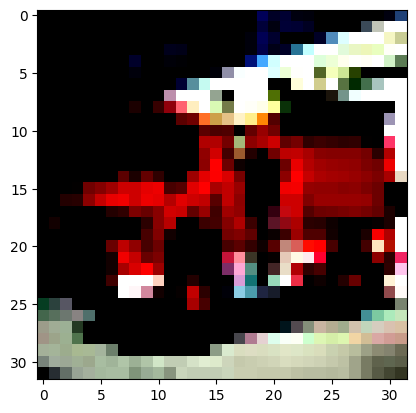

In [28]:
plt.imshow(
    torch.tensor(tmp[23][0].numpy()).permute(1, 2, 0)
)
plt.show()


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [29]:
labels[np.argmax(cifar_module(tmp[23][0].unsqueeze(0)).detach().numpy(), axis=1).tolist()[0]]

'truck'

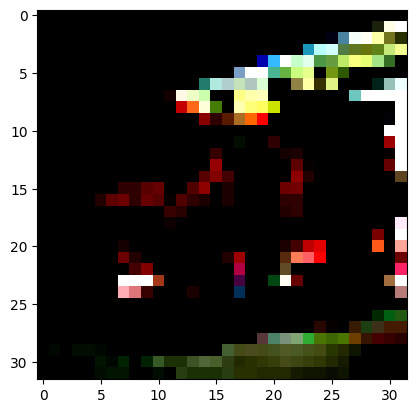

In [30]:
perturb = A.RandomBrightnessContrast(
    brightness_limit=1.5,
    contrast_limit=1.5,
    p=1.0
)

perturbed_image = torch.tensor(
    perturb(
        image=tmp[23][0].numpy(),
    )['image']
    
)

plt.imshow(
    perturbed_image.permute(1, 2, 0)
)
plt.show()
    

In [31]:
labels[np.argmax(cifar_module(perturbed_image.unsqueeze(0)).detach().numpy(), axis=1).tolist()[0]]

'dog'

### Look how prediction changed from truck to dog

In [32]:
cd.predict(xc)

{'data': {'is_drift': 0,
  'distance': -0.006183803081512451,
  'p_val': 0.9200000166893005,
  'threshold': 0.05,
  'distance_threshold': array(0.00921333, dtype=float32)},
 'meta': {'name': 'MMDDriftTorch',
  'online': False,
  'data_type': None,
  'version': '0.10.4',
  'detector_type': 'drift',
  'backend': 'pytorch'}}

## LSDD Drift (Least-Squares Density Difference)

In [40]:
from alibi_detect.cd import LSDDDrift

In [87]:
cd = LSDDDrift(x, backend='pytorch', p_val=.005, preprocess_fn=preprocess_fn)
cd.predict(xc)

{'data': {'is_drift': 0,
  'distance': 0.0020556978415697813,
  'p_val': 0.7400000095367432,
  'threshold': 0.005,
  'distance_threshold': array(0.0312476, dtype=float32)},
 'meta': {'name': 'LSDDDriftTorch',
  'online': False,
  'data_type': None,
  'version': '0.10.4',
  'detector_type': 'drift',
  'backend': 'pytorch'}}

## Kernel MMD (Torch Drift)

In [88]:
import torchdrift
import sklearn

Sometimes you are not allowed to make changes in the model, so here we can use a resnet model trained on imagenet !

In [94]:
feature_extractor = torchvision.models.resnet18(pretrained=True)
feature_extractor.fc = torch.nn.Identity()

feature_extractor = feature_extractor.to(device)

In [95]:
drift_detector = torchdrift.detectors.KernelMMDDriftDetector()

In [96]:
cifar10_train_dl = DataLoader(tmp)

In [97]:
torchdrift.utils.fit(cifar10_train_dl, feature_extractor, drift_detector)

100%|██████████| 10000/10000 [00:34<00:00, 287.36it/s]


In [98]:
drift_detection_model = torch.nn.Sequential(
    feature_extractor,
    drift_detector
).to(device)

In [101]:
perturbed_images = []

for idx in range(100):
    perturbed_image = torch.tensor(
        perturb(
            image=x[idx]
        )['image']
    )

    perturbed_images.append(perturbed_image)

perturbed_images = torch.stack(perturbed_images)

In [102]:
perturbed_images.shape

torch.Size([100, 3, 32, 32])

Perturbed Data

In [105]:
with torch.no_grad():
    features = feature_extractor(perturbed_images.to(device))
    score = drift_detector(features)
    score = drift_detection_model(perturbed_images.to(device))
    p_val = drift_detector.compute_p_value(features)
score, p_val

(tensor(0.1333, device='cuda:0'), tensor(0., device='cuda:0'))

P-Value is 0 ! that means a drift !

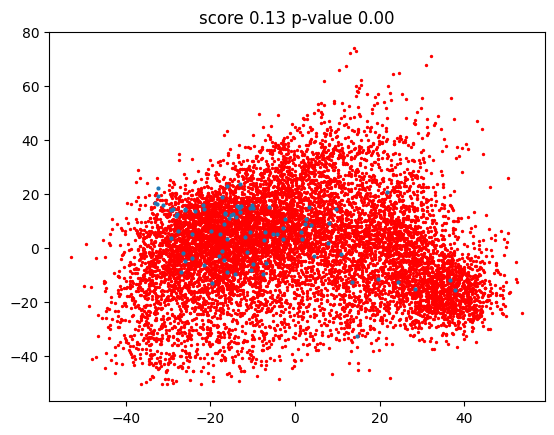

In [106]:
N_base = drift_detector.base_outputs.size(0)
mapper = sklearn.manifold.Isomap(n_components=2)
base_embedded = mapper.fit_transform(drift_detector.base_outputs.cpu())
features_embedded = mapper.transform(features.cpu().detach().numpy())
plt.scatter(base_embedded[:, 0], base_embedded[:, 1], s=2, c='r')
plt.scatter(features_embedded[:, 0], features_embedded[:, 1], s=4)
plt.title(f'score {score:.2f} p-value {p_val:.2f}')
plt.show()

Reference Data

In [110]:
with torch.no_grad():
    features = feature_extractor(torch.Tensor(xc).to(device))
    score = drift_detector(features)
    p_val = drift_detector.compute_p_value(features)
score, p_val

(tensor(0.0097, device='cuda:0'), tensor(0.6640, device='cuda:0'))

###### p value is 0.66 so it's not a drift

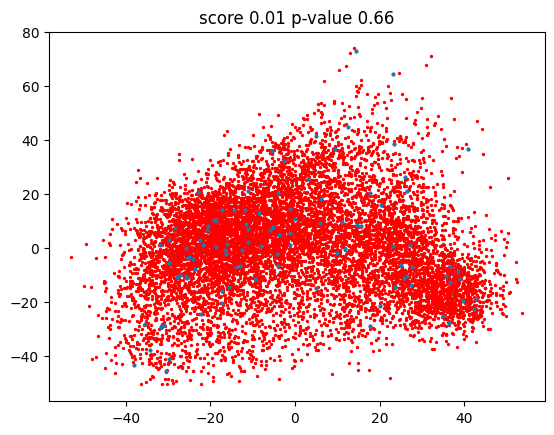

In [111]:
N_base = drift_detector.base_outputs.size(0)
mapper = sklearn.manifold.Isomap(n_components=2)
base_embedded = mapper.fit_transform(drift_detector.base_outputs.cpu())
features_embedded = mapper.transform(features.cpu().detach().numpy())
plt.scatter(base_embedded[:, 0], base_embedded[:, 1], s=2, c='r')
plt.scatter(features_embedded[:, 0], features_embedded[:, 1], s=4)
plt.title(f'score {score:.2f} p-value {p_val:.2f}')
plt.show()